In [1]:
# === Cell 0: Environment & versions (optional header) ===
import sys, platform
print("Notebook: Siamese mRGC — training")
print(f"Python  : {sys.version.split()[0]} | {platform.platform()}")

# Try to report common libs (safe if some are missing)
def _v(pkg, name):
    try:
        mod = __import__(pkg)
        print(f"{name:<8}: {getattr(mod, '__version__', 'n/a')}")
    except Exception:
        print(f"{name:<8}: (not installed)")

_v("numpy",  "NumPy")
_v("pandas", "Pandas")
_v("scipy",  "SciPy")
_v("torch",  "PyTorch")
_v("sklearn","sklearn")
_v("yaml",   "PyYAML")


Notebook: Siamese mRGC — training
Python  : 3.10.15 | macOS-15.6.1-arm64-arm-64bit
NumPy   : 2.2.6
Pandas  : 2.3.2
SciPy   : 1.15.2
PyTorch : 2.8.0
sklearn : 1.7.2
PyYAML  : 6.0.3


In [2]:
# === Cell 1: Load YAML config + resolve paths + seed/device ===
from pathlib import Path
import yaml, os, random, numpy as np, torch, pandas as pd

# Path to saved config
CFG_PATH = Path("/Users/kate/Documents/retina-model/configs/siamese_train_respLM.yaml").expanduser()

# --- Helpers ---------------------------------------------------------------
def _get_nested(d, keys, default=None):
    """Try several key paths; return the first hit."""
    for ks in keys:
        cur = d
        ok = True
        for k in ks:
            if isinstance(cur, dict) and k in cur:
                cur = cur[k]
            else:
                ok = False
                break
        if ok:
            return cur
    return default

def _expand_path(p):
    if p is None:
        return None
    return Path(os.path.expanduser(str(p))).resolve()

def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Determinism knobs (safe on CPU; CUDA warns if unsupported ops appear)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# --- Load YAML -------------------------------------------------------------
assert CFG_PATH.exists(), f"Config not found: {CFG_PATH}"
with open(CFG_PATH, "r") as f:
    CFG = yaml.safe_load(f)

# --- Resolve critical paths (supporting a few possible YAML shapes) --------
CSV_PATH = _expand_path(_get_nested(
    CFG,
    keys=[("data","csv_path"), ("paths","csv_path"), ("csv_path",)],
    default="/Users/kate/Documents/retina-model/2025-11-13_pilot_patch/manifests/trials.csv"
))

RUN_DIR = _expand_path(_get_nested(
    CFG,
    keys=[("data","run_dir"), ("paths","run_dir"), ("run_dir",)],
    default="/Users/kate/Documents/retina-model/20251113_runAllImages"
))

# Checkpoint directory
CKPT_DIR = _expand_path(_get_nested(
    CFG,
    keys=[("logging","ckpt_dir"), ("train","ckpt_dir"), ("ckpt_dir",)],
    default="/Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints"
))
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Splits (optional in YAML; default to standard)
SPLITS = _get_nested(CFG, keys=[("data","splits"), ("splits",)], default=["train","val","test"])
SPLITS = list(SPLITS)

# Batch sizes
BATCH_TRAIN = int(_get_nested(CFG, [("data","batch_train"), ("train","batch_train"), ("batch_train",)], 16))
BATCH_VAL   = int(_get_nested(CFG, [("data","batch_val"),   ("train","batch_val"),   ("batch_val",)],   32))

# Randomization flags (from YAML; supports bool or per-split dict)
RAND_FLAGS_RAW = _get_nested(CFG, [("data","randomize_candidates"), ("randomize_candidates",)], True)
if isinstance(RAND_FLAGS_RAW, bool):
    RAND_FLAGS = {"train": RAND_FLAGS_RAW, "val": RAND_FLAGS_RAW, "test": RAND_FLAGS_RAW}
else:
    RAND_FLAGS = {
        "train": bool(_get_nested(RAND_FLAGS_RAW, [("train",)], True)),
        "val":   bool(_get_nested(RAND_FLAGS_RAW, [("val",)],   True)),
        "test":  bool(_get_nested(RAND_FLAGS_RAW, [("test",)],  True)),
    }
print(f"Randomize    : {RAND_FLAGS}")

# Model knobs
ENC_HIDDEN   = _get_nested(CFG, [("model","encoder_hidden"), ("encoder_hidden",)], [128,64,32])
USE_COMP     = bool(_get_nested(CFG, [("model","use_comparator"), ("use_comparator",)], False))
COMP_PRODUCTS= bool(_get_nested(CFG, [("model","comparator_use_products"), ("comparator_use_products",)], False))

# Optim/scheduler
LR       = float(_get_nested(CFG, [("optim","lr"), ("lr",)], 1e-3))
WD       = float(_get_nested(CFG, [("optim","weight_decay"), ("weight_decay",)], 1e-4))
EPOCHS   = int(_get_nested(CFG,  [("optim","epochs"), ("epochs",)], 100))
PATIENCE = int(_get_nested(CFG,  [("optim","early_stopping_patience"), ("early_stopping_patience",)], 8))
GRAD_CLIP= float(_get_nested(CFG, [("optim","grad_clip_norm"), ("grad_clip_norm",)], 1.0))

USE_COSINE   = bool(_get_nested(CFG, [("scheduler","use_cosine"), ("use_cosine",)], True))
WARMUP_EPOCHS= int(_get_nested(CFG, [("scheduler","warmup_epochs"), ("warmup_epochs",)], 5))

USE_AMP = bool(_get_nested(CFG, [("amp","enabled"), ("use_amp",)], False))

# Seed & device
SEED = int(_get_nested(CFG, [("seed",)], 1234))
set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Path existence checks & quick manifest sanity ------------------------
print("=== Config summary ===")
print(f"CFG file     : {CFG_PATH}")
print(f"CSV path     : {CSV_PATH}  | exists={CSV_PATH.exists()}")
print(f"Run dir      : {RUN_DIR}   | exists={RUN_DIR.exists()}")
print(f"Checkpoint   : {CKPT_DIR}  | exists=True")
print(f"Splits       : {SPLITS}")
print(f"Batches      : train={BATCH_TRAIN}  val={BATCH_VAL}")
print(f"Randomize    : {RAND_FLAGS}")
print(f"Encoder dims : {ENC_HIDDEN}  | use_comparator={USE_COMP}  | comparator_products={COMP_PRODUCTS}")
print(f"Optim        : lr={LR}  wd={WD}  epochs={EPOCHS}  patience={PATIENCE}  grad_clip={GRAD_CLIP}")
print(f"Scheduler    : cosine={USE_COSINE}  warmup_epochs={WARMUP_EPOCHS}")
print(f"Mixed precision (AMP): {USE_AMP}")
print(f"Device/seed  : {DEVICE.type} / {SEED}")

# Hard checks that must pass for the next cells
assert CSV_PATH.exists(), "trials.csv not found — check CSV path in YAML."
assert RUN_DIR.exists(),  "run outputs dir not found — check run_dir in YAML."

# Quick peek at the manifest: row count and split distribution
try:
    _df = pd.read_csv(CSV_PATH)
    split_counts = _df["split"].value_counts().to_dict() if "split" in _df.columns else {}
    print(f"Manifest rows: {len(_df)} | split counts: {split_counts}")
except Exception as e:
    print(f"(Note) Could not read manifest CSV for a quick peek: {e}")
    split_counts = {}


Randomize    : {'train': True, 'val': False, 'test': False}
=== Config summary ===
CFG file     : /Users/kate/Documents/retina-model/configs/siamese_train_respLM.yaml
CSV path     : /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/manifests/trials.csv  | exists=True
Run dir      : /Users/kate/Documents/retina-model/20251113_runAllImages   | exists=True
Checkpoint   : /Users/kate/Documents/retina-model/notebooks/checkpoints_respLM  | exists=True
Splits       : ['train', 'val', 'test']
Batches      : train=16  val=32
Randomize    : {'train': True, 'val': False, 'test': False}
Encoder dims : [128, 64, 32]  | use_comparator=False  | comparator_products=False
Optim        : lr=0.001  wd=0.0001  epochs=100  patience=8  grad_clip=1.0
Scheduler    : cosine=True  warmup_epochs=5
Mixed precision (AMP): False
Device/seed  : cpu / 1234
Manifest rows: 300 | split counts: {'train': 200, 'val': 50, 'test': 50}


In [4]:
# === Cell 3: Whole-dataset QC (lengths/positions) + simple L2 baseline ===
import os, numpy as np, pandas as pd
from pathlib import Path
from scipy.io import loadmat

assert 'CSV_PATH' in globals() and 'RUN_DIR' in globals(), "Run Cell 1 first."

# Which response vector to read from .mat files: 'respLM' or 'respLMS'
RESP_KEY = globals().get(
    'RESP_KEY',
    ( _get_nested(CFG, [("data","response_key"), ("response_key",)], "respLM")
      if 'CFG' in globals() else "respLMS" )
)

def _load_vec(mat_path, key):
    d = loadmat(mat_path, simplify_cells=True)
    if key not in d:
        raise KeyError(f"'{key}' not in {os.path.basename(mat_path)}. Keys: {list(d.keys())}")
    v = np.ravel(np.asarray(d[key])).astype(np.float64)
    if not np.isfinite(v).all():
        raise ValueError(f"Non-finite values in {os.path.basename(mat_path)}")
    pos = d.get("rgc_positions", None)
    if pos is not None:
        pos = np.asarray(pos, float)
    return v, pos

df = pd.read_csv(CSV_PATH).query("split in ['train','val','test']").copy()

issues = []
vec_lengths = set()
pos_ref = None
pos_mismatch = False

n_trials = 0
n_baseline_correct = 0

# Per-cell variance on TRAIN (Welford)
train_count = 0
m_mean = None
m_M2   = None

for _, row in df.iterrows():
    split = row["split"]
    tid   = int(row["trial_id"])
    pA = _mat_path(RUN_DIR, split, tid, "initial")
    pT = _mat_path(RUN_DIR, split, tid, "candT")
    pF = _mat_path(RUN_DIR, split, tid, "candF")

    missing = [p for p in (pA,pT,pF) if not Path(p).exists()]
    if missing:
        issues.append(f"[{split} #{tid:06d}] Missing: {missing[0]}")
        continue

    try:
        a, pa = _load_vec(pA, RESP_KEY)
        t, _  = _load_vec(pT, RESP_KEY)
        f, _  = _load_vec(pF, RESP_KEY)
    except Exception as e:
        issues.append(f"[{split} #{tid:06d}] Load error: {e}")
        continue

    if not (len(a)==len(t)==len(f)):
        issues.append(f"[{split} #{tid:06d}] Lengths differ: A{len(a)} T{len(t)} F{len(f)}")
        continue

    D = len(a)
    vec_lengths.add(D)

    if pa is not None:
        if pos_ref is None:
            pos_ref = pa
        elif pa.shape != pos_ref.shape or not np.allclose(pa, pos_ref):
            pos_mismatch = True

    # L2 baseline: predict candT if ‖A−T‖ < ‖A−F‖
    n_baseline_correct += (np.linalg.norm(a - t) < np.linalg.norm(a - f))
    n_trials += 1

    # Welford variance on TRAIN anchors
    if split == "train":
        train_count += 1
        x = a
        if m_mean is None:
            m_mean = np.zeros(D, dtype=np.float64)
            m_M2   = np.zeros(D, dtype=np.float64)
        delta = x - m_mean
        m_mean += delta / train_count
        m_M2   += delta * (x - m_mean)

# --- Print summary
print(f"Using run outputs: {RUN_DIR}")
print(f"Trials scanned: {n_trials} (splits: train, val, test)")
print(f"Unique vector lengths: {sorted(vec_lengths)}")
print("RGC positions:", "consistent" if (pos_ref is not None and not pos_mismatch)
      else ("missing" if pos_ref is None else "MISMATCH"))

if issues:
    print("\nIssues found:", len(issues))
    for msg in issues[:10]:
        print("  -", msg)
    if len(issues) > 10:
        print(f"  ... and {len(issues)-10} more")
else:
    print("\nNo missing files or load errors detected.")

if n_trials > 0:
    baseline_acc = n_baseline_correct / n_trials
    print(f"\nDistance baseline (L2): {baseline_acc:.3f}  "
          f"(fraction with ‖A−T‖ < ‖A−F‖; chance = 0.5)")

if train_count > 1:
    var = m_M2 / (train_count - 1)
    nz_frac = float(np.mean(var > 0))
    print(f"Per-cell variance on TRAIN: {nz_frac*100:.1f}% of cells have non-zero variance across trials")


Using run outputs: /Users/kate/Documents/retina-model/20251113_runAllImages
Trials scanned: 300 (splits: train, val, test)
Unique vector lengths: [10371]
RGC positions: consistent

No missing files or load errors detected.

Distance baseline (L2): 0.017  (fraction with ‖A−T‖ < ‖A−F‖; chance = 0.5)
Per-cell variance on TRAIN: 100.0% of cells have non-zero variance across trials


In [3]:
# === Cell 2: Dataset & DataLoaders (respLM *or* respLMS; YAML-driven) ===
import os, numpy as np, pandas as pd
from pathlib import Path
from scipy.io import loadmat
import torch
from torch.utils.data import Dataset, DataLoader

# Pull config from Cell 1
assert 'CSV_PATH' in globals() and 'RUN_DIR' in globals() and 'CFG' in globals(), "Run Cell 1 first."

# Which response to load from .mat files: 'respLM' or 'respLMS'
try:
    RESP_KEY = _get_nested(CFG, [("data","response_key"), ("response_key",)], "respLM")
except NameError:
    # Fallback if _get_nested isn't in scope for some reason
    RESP_KEY = CFG.get("data", {}).get("response_key", "respLMS")
RESP_KEY = str(RESP_KEY)

# --- Helpers to map trial→.mat paths (no need to touch PNG/TIFF paths) ----
def _mat_name(trial_id_str, stem):  # stem ∈ {'initial','candT','candF'}
    return f"mRGCresp_trial_{trial_id_str}_{stem}_XYZ_dt10ms_T10.mat"

def _mat_path(run_root: Path, split: str, trial_id: int, stem: str) -> Path:
    return Path(run_root) / split / _mat_name(f"{int(trial_id):06d}", stem)

def _as_1d(a):
    a = np.asarray(a)
    return np.ravel(a).astype(np.float32)

# --- Dataset ---------------------------------------------------------------
class MRGCTriplets(Dataset):
    """
    Loads (anchor=initial, candT=true, candF=impostor) response vectors from .mat files.
    The response to use is controlled by `response_key` (e.g., 'respLM' or 'respLMS').
    Optionally randomizes candidate order on-the-fly and flips the label accordingly.
    """
    def __init__(self, csv_path: Path, run_dir: Path, split: str,
                 randomize_candidates: bool = True,
                 response_key: str = "respLM"):
        self.split = split
        self.randomize = bool(randomize_candidates)
        self.response_key = str(response_key)

        df = pd.read_csv(csv_path)
        self.df = (df[df["split"] == split]
                   .sort_values("trial_id")
                   .reset_index(drop=True))

        # Precompute file paths for speed
        self.mats = []
        for _, r in self.df.iterrows():
            tid = int(r["trial_id"])
            mI = _mat_path(run_dir, split, tid, "initial")
            mT = _mat_path(run_dir, split, tid, "candT")
            mF = _mat_path(run_dir, split, tid, "candF")
            self.mats.append((mI, mT, mF))

        assert len(self.mats) > 0, f"No trials found for split='{split}'"

        # Probe dimension once
        v0 = self._load_vec(self.mats[0][0])
        self.input_dim = int(v0.shape[0])

    def _load_vec(self, mat_path: Path) -> np.ndarray:
        d = loadmat(mat_path, squeeze_me=True)
        if self.response_key not in d:
            raise KeyError(f"'{self.response_key}' not in {mat_path.name}; keys: {list(d.keys())}")
        v = _as_1d(d[self.response_key])
        if not np.isfinite(v).all():
            raise ValueError(f"Non-finite values in {mat_path.name} for key '{self.response_key}'")
        return v

    def __len__(self): return len(self.mats)

    def __getitem__(self, idx):
        mI, mT, mF = self.mats[idx]
        xA = self._load_vec(mI)  # anchor (initial)
        xT = self._load_vec(mT)  # true match
        xF = self._load_vec(mF)  # impostor

        # Label convention: 1 means "current candT is correct"
        label = 1.0
        if self.randomize and np.random.rand() < 0.5:
            # Swap and flip label so the task stays the same but position is hidden
            xT, xF = xF, xT
            label = 0.0

        return {
            "anchor": torch.from_numpy(xA),
            "candT":  torch.from_numpy(xT),
            "candF":  torch.from_numpy(xF),
            "label":  torch.tensor(label, dtype=torch.float32),
            "trial_id": int(self.df.iloc[idx]["trial_id"]),
        }

# --- Build datasets/loaders from YAML options --------------------------------
NUM_WORKERS = int(_get_nested(CFG, [("data","num_workers"), ("num_workers",)], 0))

train_set = MRGCTriplets(CSV_PATH, RUN_DIR, "train",
                         randomize_candidates=RAND_FLAGS["train"],
                         response_key=RESP_KEY)
val_set   = MRGCTriplets(CSV_PATH, RUN_DIR, "val",
                         randomize_candidates=RAND_FLAGS["val"],
                         response_key=RESP_KEY)
test_set  = MRGCTriplets(CSV_PATH, RUN_DIR, "test",
                         randomize_candidates=RAND_FLAGS["test"],
                         response_key=RESP_KEY)

# Infer input D from the dataset probe
D_in = train_set.input_dim

train_loader = DataLoader(train_set, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_set,   batch_size=BATCH_VAL,   shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_set,  batch_size=BATCH_VAL,   shuffle=False, num_workers=NUM_WORKERS)

# --- Quick checks -------------------------------------------------------------
def _label_mean(loader, n_batches=10):
    c, n = 0.0, 0
    it = iter(loader)
    for _ in range(n_batches):
        try:
            b = next(it)
        except StopIteration:
            break
        c += float(b["label"].mean())
        n += 1
    return c / max(1, n)

sample = next(iter(train_loader))
print(f"Loaded splits: train={len(train_set)}, val={len(val_set)}, test={len(test_set)}")
print(f"Vector length D: {D_in}  | response_key: {RESP_KEY}")
print("Sample batch shapes:",
      {k: (tuple(v.shape) if hasattr(v,'shape') else v) for k,v in sample.items() if k!='trial_id'})
print(f"Label mean (train): { _label_mean(train_loader):.3f}  "
      f"| (val): { _label_mean(val_loader):.3f}  "
      f"| (test): { _label_mean(test_loader):.3f}")


Loaded splits: train=200, val=50, test=50
Vector length D: 10371  | response_key: respLM
Sample batch shapes: {'anchor': (16, 10371), 'candT': (16, 10371), 'candF': (16, 10371), 'label': (16,)}
Label mean (train): 0.569  | (val): 1.000  | (test): 1.000


In [5]:
# === Cell 4: Build model (shared MLP encoder; optional comparator) ===
import torch
import torch.nn as nn
from math import sqrt

assert 'CFG' in globals() and 'train_loader' in globals() and 'DEVICE' in globals(), "Run Cells 0–3 first."

# --- Config pulls
ENC_HIDDEN = list(CFG["model"]["encoder_hidden"])
USE_COMP   = bool(CFG["model"]["use_comparator"])
USE_PROD   = bool(CFG["model"]["comparator_products"])

# Infer input D from the dataset
try:
    sample = next(iter(train_loader))
    D_IN = sample["anchor"].shape[1]
except Exception as e:
    raise RuntimeError("Could not infer input dimension from train_loader.") from e

# --- Small MLP builder
def mlp(in_dim, hidden_dims):
    layers, dims = [], [in_dim] + list(hidden_dims)
    for i in range(len(dims)-1):
        layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU(inplace=True)]
    return nn.Sequential(*layers)

# --- Encoder
class SharedEncoder(nn.Module):
    def __init__(self, in_dim, hidden):
        super().__init__()
        self.net = mlp(in_dim, hidden)
        self.out_dim = hidden[-1]
    def forward(self, x):  # x: [B, D]
        return self.net(x)

# --- Comparator head (only used if USE_COMP=True)
class ComparatorHead(nn.Module):
    """
    Features = concat(|zA−zT|, |zA−zF|[, zA∘zT, zA∘zF]) → MLP → 1 logit
    """
    def __init__(self, emb_dim, use_products=False):
        super().__init__()
        feat_dim = (2 * emb_dim) if not use_products else (4 * emb_dim)
        self.use_products = use_products
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 64), nn.ReLU(inplace=True),
            nn.Linear(64, 16), nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )
    def forward(self, zA, zT, zF):
        feats = [torch.abs(zA - zT), torch.abs(zA - zF)]
        if self.use_products:
            feats += [zA * zT, zA * zF]
        x = torch.cat(feats, dim=1)
        return self.head(x).squeeze(1)  # [B]

# --- Siamese wrapper (comparator optional)
class SiameseModel(nn.Module):
    def __init__(self, in_dim, enc_hidden, use_comparator=False, use_products=False):
        super().__init__()
        self.encoder = SharedEncoder(in_dim, enc_hidden)
        self.use_comparator = bool(use_comparator)
        if self.use_comparator:
            self.comparator = ComparatorHead(self.encoder.out_dim, use_products)
        else:
            # No comparator: use distance-difference as the logit (learn-free)
            self.register_buffer("one", torch.tensor(1.0))  # keeps dtype/device tidy

    def forward(self, anchor, candT, candF, return_embeddings=False):
        zA = self.encoder(anchor.float())
        zT = self.encoder(candT.float())
        zF = self.encoder(candF.float())

        if self.use_comparator:
            logit = self.comparator(zA, zT, zF)
        else:
            # Positive logit when T is closer than F (good for label=1 with BCEWithLogits)
            dT = torch.linalg.vector_norm(zA - zT, dim=1)
            dF = torch.linalg.vector_norm(zA - zF, dim=1)
            logit = (dF - dT) * self.one  # shape [B]

        if return_embeddings:
            return logit, (zA, zT, zF)
        return logit

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# Build & dry-run
model = SiameseModel(
    in_dim=D_IN,
    enc_hidden=ENC_HIDDEN,
    use_comparator=USE_COMP,
    use_products=USE_PROD
).to(DEVICE)

print(f"Model on {DEVICE.type}: D={D_IN} → {ENC_HIDDEN} | comparator={USE_COMP} "
      f"(products={USE_PROD}) | params={count_params(model):,}")

# Smoke test
model.eval()
with torch.no_grad():
    a = sample["anchor"].to(DEVICE).float()
    t = sample["candT"].to(DEVICE).float()
    f = sample["candF"].to(DEVICE).float()
    out = model(a, t, f)
    print("Forward OK →", "logit", tuple(out.shape), "| dtype:", out.dtype)


Model on cpu: D=10371 → [128, 64, 32] | comparator=False (products=False) | params=1,337,952
Forward OK → logit (16,) | dtype: torch.float32


In [6]:
# === Cell 5 — Train loop (early stopping + checkpoints + per-epoch logs) ===
import math, time, json
from copy import deepcopy
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

assert 'CFG' in globals() and 'model' in globals() and 'train_loader' in globals() and 'val_loader' in globals(), \
    "Run Cells 0–4 first."

# --- Hyperparams from YAML ---
OPT        = CFG["optim"]
LR         = float(OPT.get("lr", 1e-3))
WD         = float(OPT.get("weight_decay", 1e-4))
EPOCHS     = int(OPT.get("epochs", 100))
PATIENCE   = int(OPT.get("early_stopping_patience", 8))
CLIP_NORM  = float(OPT.get("grad_clip_norm", 1.0))
SCHEDULER  = str(OPT.get("scheduler", "cosine")).lower()

# --- Checkpoint dir + run id (next to your dataset root) ---
ROOT = Path(CSV_PATH).parents[1] if 'CSV_PATH' in globals() else Path.cwd()
log_cfg = CFG.get("logging", {})
ckpt_dir_name = log_cfg.get("ckpt_dir", "checkpoints")
run_id = time.strftime("%Y%m%d_%H%M%S") if log_cfg.get("run_id", "auto") == "auto" else str(log_cfg["run_id"])
CKPT_DIR  = (ROOT / ckpt_dir_name)
CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH     = CKPT_DIR / "siamese_mlp_best.pt"
METRICS_CSV   = CKPT_DIR / f"train_metrics_{run_id}.csv"
METRICS_JSON  = CKPT_DIR / f"train_metrics_{run_id}.json"

# --- Loss / optimizer / (optional) scheduler ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS) if SCHEDULER == "cosine" else None

def _evaluate(loader):
    model.eval()
    tot_loss, n, n_correct = 0.0, 0, 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            a = batch["anchor"].to(DEVICE).float()
            t = batch["candT"].to(DEVICE).float()
            f = batch["candF"].to(DEVICE).float()
            y = batch["label"].to(DEVICE).float()

            logits = model(a, t, f)
            loss   = criterion(logits, y)
            probs  = torch.sigmoid(logits)
            pred   = (probs >= 0.5).float()

            bs = y.shape[0]
            tot_loss += loss.item() * bs
            n        += bs
            n_correct += (pred == y).sum().item()

            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    mean_loss = tot_loss / max(n, 1)
    acc = n_correct / max(n, 1)

    # AUC (prints 'n/a' if single class)
    try:
        import numpy as np
        from sklearn.metrics import roc_auc_score
        probs  = torch.cat(all_probs).numpy()
        labels = torch.cat(all_labels).numpy()
        auc = float("nan") if len(set(labels.tolist())) < 2 else float(roc_auc_score(labels, probs))
    except Exception:
        auc = float("nan")

    return mean_loss, acc, auc

# --- Training loop with early stopping + metric logging ---
best_val, best_state, wait = math.inf, None, 0
metrics = []  # per-epoch dicts
print(f"Starting training for up to {EPOCHS} epochs; early stopping patience={PATIENCE}")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, n_seen, n_correct = 0.0, 0, 0

    for batch in train_loader:
        a = batch["anchor"].to(DEVICE).float()
        t = batch["candT"].to(DEVICE).float()
        f = batch["candF"].to(DEVICE).float()
        y = batch["label"].to(DEVICE).float()

        optimizer.zero_grad(set_to_none=True)
        logits = model(a, t, f)
        loss   = criterion(logits, y)
        loss.backward()

        if CLIP_NORM and CLIP_NORM > 0:
            nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)

        optimizer.step()

        probs = torch.sigmoid(logits)
        pred  = (probs >= 0.5).float()
        bs = y.shape[0]
        running_loss += loss.item() * bs
        n_seen       += bs
        n_correct    += (pred == y).sum().item()

    train_loss = running_loss / max(1, n_seen)
    train_acc  = n_correct / max(1, n_seen)

    # Validation
    val_loss, val_acc, val_auc = _evaluate(val_loader)

    # Scheduler + LR readout
    if scheduler is not None:
        scheduler.step()
        lr_now = scheduler.get_last_lr()[0]
    else:
        lr_now = LR

    # Log + print
    row = {
        "epoch": epoch,
        "train_loss": float(train_loss),
        "train_acc":  float(train_acc),
        "val_loss":   float(val_loss),
        "val_acc":    float(val_acc),
        "val_auc":    (None if math.isnan(val_auc) else float(val_auc)),
        "lr":         float(lr_now),
        "time_s":     float(time.time() - t0),
    }
    metrics.append(row)

    print(f"Epoch {epoch:03d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f} auc {('n/a' if math.isnan(val_auc) else f'{val_auc:.3f}')} | "
          f"lr {lr_now:.5f}")

    # Early stopping on val loss
    if val_loss < best_val - 1e-6:
        best_val, wait = val_loss, 0
        best_state = deepcopy(model.state_dict())
        torch.save(best_state, BEST_PATH)
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no val loss improvement for {wait} epochs).")
            break

# Restore best checkpoint
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restored best checkpoint from {BEST_PATH} (val loss={best_val:.4f})")
else:
    print("Warning: no best_state captured; training may have failed early.")

# Save per-epoch metrics to CSV + JSON for plotting later
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv(METRICS_CSV, index=False)
with open(METRICS_JSON, "w") as f:
    json.dump({"run_id": run_id, "metrics": metrics}, f, indent=2)

print(f"Saved metrics:\n  CSV : {METRICS_CSV}\n  JSON: {METRICS_JSON}")
print(f"Training done in {time.time()-t0:.1f}s")


Starting training for up to 100 epochs; early stopping patience=8
Epoch 001 | train loss 0.5866 acc 0.660 | val loss 0.1318 acc 0.940 auc n/a | lr 0.00100
Epoch 002 | train loss 0.3224 acc 0.925 | val loss 0.1641 acc 0.940 auc n/a | lr 0.00100
Epoch 003 | train loss 0.2547 acc 0.915 | val loss 0.1087 acc 0.940 auc n/a | lr 0.00100
Epoch 004 | train loss 0.2155 acc 0.935 | val loss 0.1047 acc 0.940 auc n/a | lr 0.00100
Epoch 005 | train loss 0.1485 acc 0.955 | val loss 0.1735 acc 0.940 auc n/a | lr 0.00099
Epoch 006 | train loss 0.2256 acc 0.945 | val loss 0.1189 acc 0.960 auc n/a | lr 0.00099
Epoch 007 | train loss 0.1059 acc 0.975 | val loss 0.1881 acc 0.920 auc n/a | lr 0.00099
Epoch 008 | train loss 0.0772 acc 0.985 | val loss 0.0997 acc 0.940 auc n/a | lr 0.00098
Epoch 009 | train loss 0.1024 acc 0.980 | val loss 0.0833 acc 0.960 auc n/a | lr 0.00098
Epoch 010 | train loss 0.0645 acc 0.980 | val loss 0.1477 acc 0.940 auc n/a | lr 0.00098
Epoch 011 | train loss 0.0615 acc 0.980 | va

In [7]:
# === Cell 6 — Validate (reload best checkpoint; detailed report + save JSON) ===
import json, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn

# Preconditions
assert 'model' in globals() and 'val_loader' in globals() and 'CFG' in globals(), "Run Cells 0–5 first."
assert 'CSV_PATH' in globals() and 'DEVICE' in globals(), "CSV_PATH/DEVICE missing; re-run Cell 1."

# Recreate checkpoint path (matches Cell 5 logic)
ROOT = Path(CSV_PATH).parents[1]
ckpt_dir_name = CFG.get("logging", {}).get("ckpt_dir", "checkpoints")
CKPT_DIR  = (ROOT / ckpt_dir_name)
CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH = CKPT_DIR / "siamese_mlp_best.pt"

# Load best checkpoint
assert BEST_PATH.exists(), f"Checkpoint not found: {BEST_PATH}"
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

criterion = nn.BCEWithLogitsLoss()

def _evaluate_collect(loader):
    """Return loss, acc(0.5), auc, probs (np), labels (np)."""
    tot_loss, n, n_correct = 0.0, 0, 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            a = batch["anchor"].to(DEVICE).float()
            t = batch["candT"].to(DEVICE).float()
            f = batch["candF"].to(DEVICE).float()
            y = batch["label"].to(DEVICE).float()

            logits = model(a, t, f)
            loss   = criterion(logits, y)
            probs  = torch.sigmoid(logits)
            pred   = (probs >= 0.5).float()

            bs = y.shape[0]
            tot_loss += loss.item() * bs
            n        += bs
            n_correct += (pred == y).sum().item()

            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    mean_loss = tot_loss / max(1, n)
    acc = n_correct / max(1, n)

    probs_np  = torch.cat(all_probs).numpy() if all_probs else np.zeros((0,), np.float32)
    labels_np = torch.cat(all_labels).numpy() if all_labels else np.zeros((0,), np.float32)

    # AUC (gracefully handle single-class)
    try:
        from sklearn.metrics import roc_auc_score
        auc = float('nan') if len(set(labels_np.tolist())) < 2 else float(roc_auc_score(labels_np, probs_np))
    except Exception:
        auc = float('nan')

    return mean_loss, acc, auc, probs_np, labels_np

def _confusion_at(probs, labels, thresh=0.5):
    pred = (probs >= thresh).astype(np.float32)
    tp = float(np.sum((pred == 1) & (labels == 1)))
    tn = float(np.sum((pred == 0) & (labels == 0)))
    fp = float(np.sum((pred == 1) & (labels == 0)))
    fn = float(np.sum((pred == 0) & (labels == 1)))
    return tp, fp, tn, fn

def _best_f1(probs, labels):
    """Sweep thresholds; return (best_f1, best_thresh)."""
    from sklearn.metrics import f1_score
    uniq = np.unique(labels)
    if len(uniq) < 2:
        return float('nan'), float('nan')
    best_f1, best_t = -1.0, 0.5
    for t in np.linspace(0.05, 0.95, 19):
        f1 = f1_score(labels, (probs >= t).astype(np.float32))
        if f1 > best_f1:
            best_f1, best_t = f1, float(t)
    return float(best_f1), best_t

# Run validation evaluation
val_loss, val_acc, val_auc, v_probs, v_labels = _evaluate_collect(val_loader)
tp, fp, tn, fn = _confusion_at(v_probs, v_labels, 0.5)
best_f1, best_t = _best_f1(v_probs, v_labels)

print(f"Validation metrics (best checkpoint):")
print(f"  loss={val_loss:.4f}  acc={val_acc:.3f}  auc={'n/a' if math.isnan(val_auc) else f'{val_auc:.3f}'}")
print(f"  confusion @0.5: TP={tp:.0f} FP={fp:.0f} TN={tn:.0f} FN={fn:.0f}")
if not math.isnan(best_f1):
    print(f"  best F1={best_f1:.3f} at threshold={best_t:.2f}")

# Save JSON report
val_report = {
    "loss": val_loss,
    "acc": val_acc,
    "auc": None if math.isnan(val_auc) else val_auc,
    "confusion@0.5": {"TP": tp, "FP": fp, "TN": tn, "FN": fn},
    "best_f1": None if math.isnan(best_f1) else best_f1,
    "best_f1_threshold": None if math.isnan(best_f1) else best_t,
    "checkpoint": str(BEST_PATH),
}
VAL_JSON = CKPT_DIR / "val_metrics.json"
with open(VAL_JSON, "w") as f:
    json.dump(val_report, f, indent=2)
print(f"Saved: {VAL_JSON}")


Validation metrics (best checkpoint):
  loss=0.0833  acc=0.960  auc=n/a
  confusion @0.5: TP=48 FP=0 TN=0 FN=2
Saved: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints_respLM/val_metrics.json


In [8]:
# === Cell 7 — Test evaluation (reload best; compare to distance baseline; save JSON) ===
import json, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn

# Preconditions
assert 'model' in globals() and 'test_loader' in globals() and 'CFG' in globals(), "Run prior cells first."
assert 'CSV_PATH' in globals() and 'DEVICE' in globals(), "CSV_PATH/DEVICE missing; re-run Cell 1."

# Paths
ROOT = Path(CSV_PATH).parents[1]
ckpt_dir_name = CFG.get("logging", {}).get("ckpt_dir", "checkpoints")
CKPT_DIR  = (ROOT / ckpt_dir_name)
BEST_PATH = CKPT_DIR / "siamese_mlp_best.pt"
assert BEST_PATH.exists(), f"Checkpoint not found: {BEST_PATH}"

# Reload best checkpoint
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

criterion = nn.BCEWithLogitsLoss()

def _evaluate_collect(loader):
    tot_loss, n, n_correct = 0.0, 0, 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            a = batch["anchor"].to(DEVICE).float()
            t = batch["candT"].to(DEVICE).float()
            f = batch["candF"].to(DEVICE).float()
            y = batch["label"].to(DEVICE).float()

            logits = model(a, t, f)
            loss   = criterion(logits, y)
            probs  = torch.sigmoid(logits)
            pred   = (probs >= 0.5).float()

            bs = y.shape[0]
            tot_loss += loss.item() * bs
            n        += bs
            n_correct += (pred == y).sum().item()

            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    mean_loss = tot_loss / max(1, n)
    acc = n_correct / max(1, n)
    probs_np  = torch.cat(all_probs).numpy() if all_probs else np.zeros((0,), np.float32)
    labels_np = torch.cat(all_labels).numpy() if all_labels else np.zeros((0,), np.float32)

    try:
        from sklearn.metrics import roc_auc_score
        auc = float('nan') if len(set(labels_np.tolist())) < 2 else float(roc_auc_score(labels_np, probs_np))
    except Exception:
        auc = float('nan')

    return mean_loss, acc, auc, probs_np, labels_np

def _distance_baseline(loader):
    """Raw-space L2 baseline: predict candT if ‖A−T‖ < ‖A−F‖."""
    n, n_correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            a = batch["anchor"].float()
            t = batch["candT"].float()
            f = batch["candF"].float()
            dT = torch.linalg.vector_norm(a - t, dim=1)
            dF = torch.linalg.vector_norm(a - f, dim=1)
            pred_is_T = (dT < dF).float()      # 1 means "T closer"
            y = batch["label"].float()         # 1 means "current T is true"
            n_correct += (pred_is_T == y).sum().item()
            n += y.shape[0]
    return n_correct / max(1, n)

# Run test evaluation
test_loss, test_acc, test_auc, t_probs, t_labels = _evaluate_collect(test_loader)
baseline_acc = _distance_baseline(test_loader)

print("Test metrics (best checkpoint):")
print(f"  loss={test_loss:.4f}  acc={test_acc:.3f}  auc={'n/a' if math.isnan(test_auc) else f'{test_auc:.3f}'}")
print(f"  distance baseline (raw L2): acc={baseline_acc:.3f}")

# Save JSON report
test_report = {
    "loss": test_loss,
    "acc": test_acc,
    "auc": None if math.isnan(test_auc) else test_auc,
    "baseline_l2_acc": baseline_acc,
    "checkpoint": str(BEST_PATH),
}
TEST_JSON = CKPT_DIR / "test_metrics.json"
with open(TEST_JSON, "w") as f:
    json.dump(test_report, f, indent=2)
print(f"Saved: {TEST_JSON}")


Test metrics (best checkpoint):
  loss=0.1353  acc=0.960  auc=n/a
  distance baseline (raw L2): acc=0.020
Saved: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints_respLM/test_metrics.json


Loaded metrics: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints_respLM/train_metrics_20251117_091429.csv
Epochs logged: 17 | Columns: ['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_auc', 'lr', 'time_s']


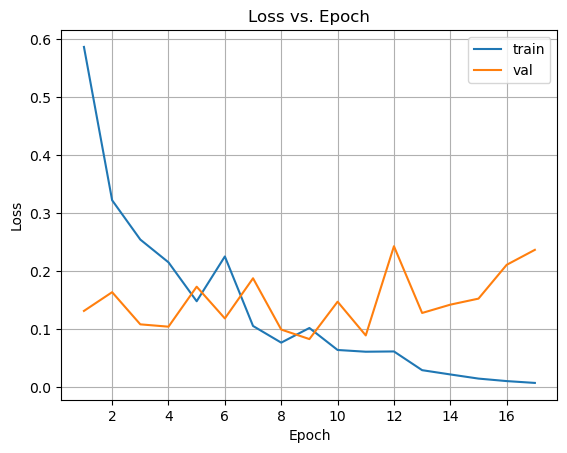

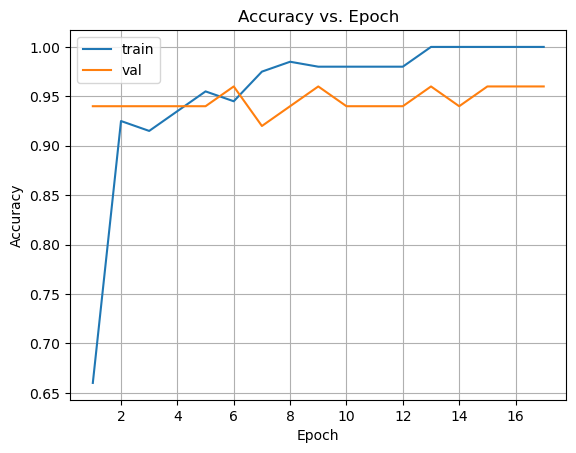

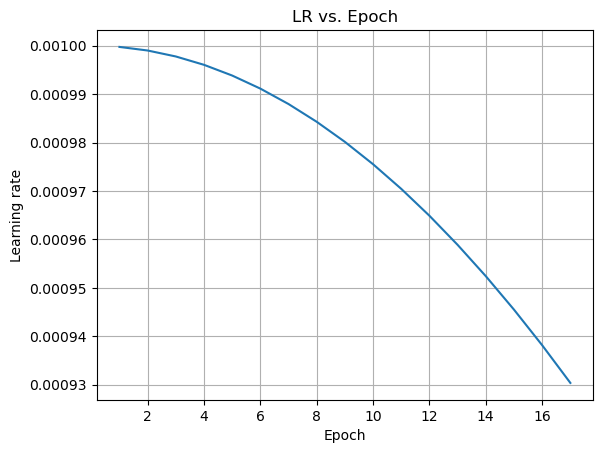

In [9]:
# === Cell 8 — Training curves (plots from saved metrics) ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Locate the checkpoints dir as in Cell 5
ROOT = Path(CSV_PATH).parents[1] if 'CSV_PATH' in globals() else Path.cwd()
ckpt_dir_name = CFG.get("logging", {}).get("ckpt_dir", "checkpoints")
CKPT_DIR = (ROOT / ckpt_dir_name)

# Pick the most recent metrics CSV (or adjust to a specific run_id if you prefer)
cands = sorted(CKPT_DIR.glob("train_metrics_*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
assert cands, f"No metrics CSV found in {CKPT_DIR}"
METRICS_CSV = cands[0]
df = pd.read_csv(METRICS_CSV)

print(f"Loaded metrics: {METRICS_CSV}")
print(f"Epochs logged: {len(df)} | Columns: {list(df.columns)}")

# --- Loss curve ---
plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="train")
plt.plot(df["epoch"], df["val_loss"],   label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs. Epoch")
plt.legend(); plt.grid(True)
plt.show()

# --- Accuracy curve ---
plt.figure()
plt.plot(df["epoch"], df["train_acc"], label="train")
plt.plot(df["epoch"], df["val_acc"],   label="val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy vs. Epoch")
plt.legend(); plt.grid(True)
plt.show()

# --- Learning-rate curve (if present) ---
if "lr" in df.columns:
    plt.figure()
    plt.plot(df["epoch"], df["lr"])
    plt.xlabel("Epoch"); plt.ylabel("Learning rate"); plt.title("LR vs. Epoch")
    plt.grid(True)
    plt.show()


Test set: n=50 | positive fraction=1.000


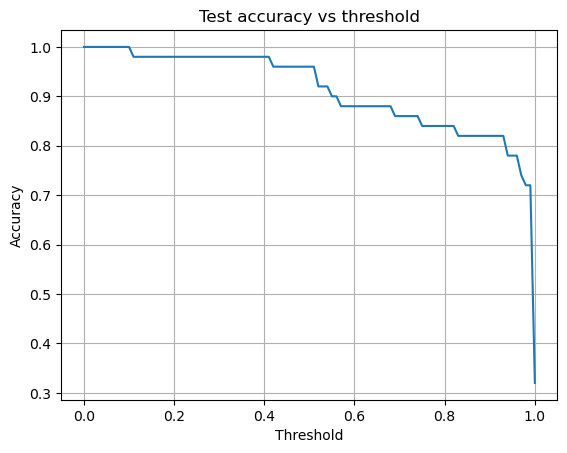

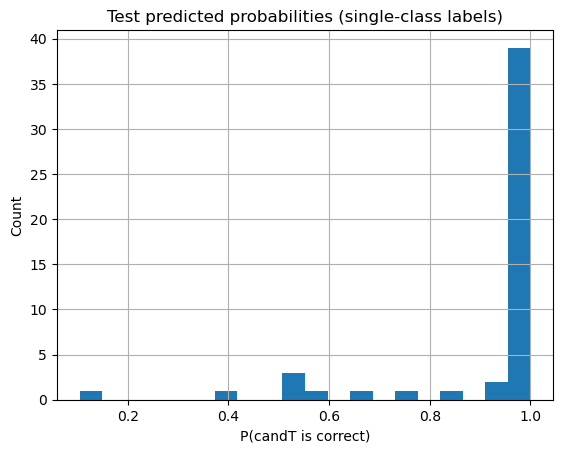

ROC/PR skipped: test labels contain a single class.
Tip: set data.randomize_candidates.test: true in YAML and rebuild loaders to enable ROC/PR.
Confusion matrix skipped: single-class labels.


In [10]:
# === Cell 8b — Test-set performance plots (ROC/PR if available) ===
import numpy as np, torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix

assert 'model' in globals() and 'test_loader' in globals() and 'DEVICE' in globals(), "Run earlier cells first."

model.eval()
probs, labels, logits = [], [], []

with torch.no_grad():
    for b in test_loader:
        a = b["anchor"].to(DEVICE).float()
        t = b["candT"].to(DEVICE).float()
        f = b["candF"].to(DEVICE).float()
        y = b["label"].cpu().numpy().astype(np.float64)

        lg = model(a, t, f).cpu().numpy()           # logits
        pr = 1.0 / (1.0 + np.exp(-lg))              # probabilities

        logits.append(lg)
        probs.append(pr)
        labels.append(y)

probs  = np.concatenate(probs)
logits = np.concatenate(logits)
labels = np.concatenate(labels)
pos_frac = labels.mean()

print(f"Test set: n={labels.size} | positive fraction={pos_frac:.3f}")

# 1) Accuracy vs threshold
ths  = np.linspace(0.0, 1.0, 101)
accs = [((probs >= th).astype(np.float64) == labels).mean() for th in ths]

plt.figure()
plt.plot(ths, accs)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Test accuracy vs threshold")
plt.grid(True)
plt.show()

# 2) Probability histogram(s)
plt.figure()
uniq = np.unique(labels)
if len(uniq) == 2:
    plt.hist(probs[labels == 1], bins=20, alpha=0.6, label="label=1")
    plt.hist(probs[labels == 0], bins=20, alpha=0.6, label="label=0")
    plt.legend()
    plt.title("Test predicted probabilities by class")
else:
    plt.hist(probs, bins=20)
    plt.title("Test predicted probabilities (single-class labels)")
plt.xlabel("P(candT is correct)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 3) ROC & PR (only if both classes present)
if len(uniq) == 2:
    fpr, tpr, _ = roc_curve(labels, probs)
    auc = roc_auc_score(labels, probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC")
    plt.legend()
    plt.grid(True)
    plt.show()

    pr, rc, _ = precision_recall_curve(labels, probs)
    ap = average_precision_score(labels, probs)
    plt.figure()
    plt.plot(rc, pr, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Test Precision–Recall")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("ROC/PR skipped: test labels contain a single class.\n"
          "Tip: set data.randomize_candidates.test: true in YAML and rebuild loaders to enable ROC/PR.")

# Confusion matrix at threshold = 0.5 (only if two classes)
if len(uniq) == 2:
    pred = (probs >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels.astype(int), pred, labels=[0,1]).ravel()
    print(f"Confusion @0.5: TP={tp} FP={fp} TN={tn} FN={fn}")
else:
    print("Confusion matrix skipped: single-class labels.")


Test set: n=50 | accuracy@0.5=0.960 | mean margin=14.8560


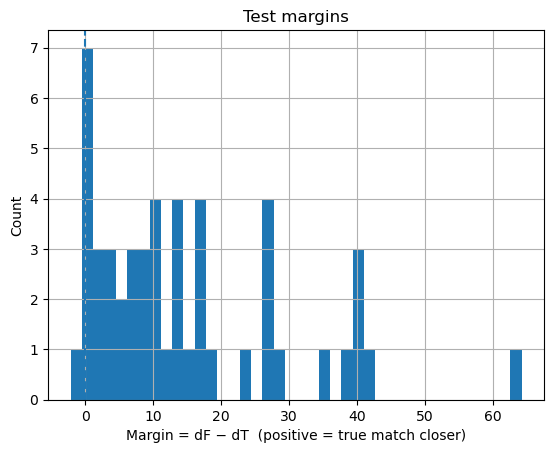

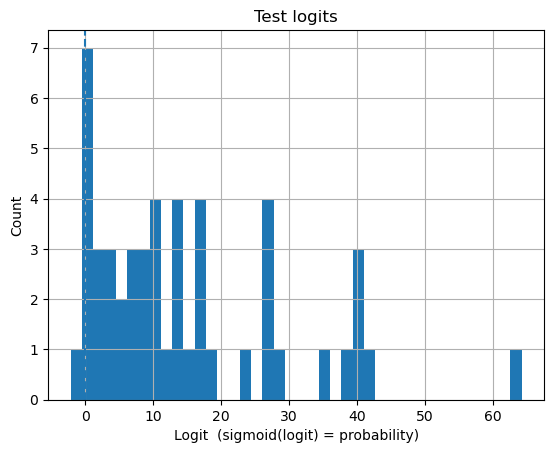


Hardest (closest calls) — top 10 by |margin|:
 trial_id  label     prob     logit    margin  correct
       31    1.0 0.513061  0.052258  0.052258        1
       30    1.0 0.513358  0.053446  0.053446        1
       16    1.0 0.542828  0.171732  0.171732        1
       22    1.0 0.562336  0.250649  0.250649        1
       37    1.0 0.414604 -0.344966 -0.344966        0
       10    1.0 0.683598  0.770355  0.770355        1
       32    1.0 0.749073  1.093677  1.093677        1
       33    1.0 0.828207  1.572975  1.572975        1
       43    1.0 0.104138 -2.152075 -2.152075        0
        5    1.0 0.931412  2.608578  2.608578        1

Strongest mistakes — top 10 most negative margins:
 trial_id  label     prob     logit    margin
       43    1.0 0.104138 -2.152075 -2.152075
       37    1.0 0.414604 -0.344966 -0.344966

Saved CSVs to: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints_respLM


In [11]:
# === Cell 8c — Confidence & hardest-trials analysis (margins & logits) ===
import numpy as np, torch, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

assert 'model' in globals() and 'test_loader' in globals() and 'DEVICE' in globals(), "Run earlier cells first."

def analyze_confidence(loader, name="test"):
    model.eval()
    rows = []

    with torch.no_grad():
        for b in loader:
            a = b["anchor"].to(DEVICE).float()
            t = b["candT"].to(DEVICE).float()
            f = b["candF"].to(DEVICE).float()
            y = b["label"].cpu().numpy().astype(np.float64)
            tid = np.asarray(b["trial_id"])

            # Get logits and embeddings so we can compute dF−dT, even if comparator=True
            logits, (zA, zT, zF) = model(a, t, f, return_embeddings=True)
            logits = logits.cpu().numpy()
            probs  = 1.0 / (1.0 + np.exp(-logits))

            # Distances in embedding space
            dT = torch.linalg.vector_norm(zA - zT, dim=1).cpu().numpy()
            dF = torch.linalg.vector_norm(zA - zF, dim=1).cpu().numpy()
            margin = dF - dT   # >0 means T is closer than F

            # Predictions at 0.5 threshold
            pred = (probs >= 0.5).astype(np.float64)
            correct = (pred == y).astype(np.float64)

            for i in range(len(y)):
                rows.append({
                    "trial_id": int(tid[i]),
                    "label": float(y[i]),
                    "prob": float(probs[i]),
                    "logit": float(logits[i]),
                    "dT": float(dT[i]),
                    "dF": float(dF[i]),
                    "margin": float(margin[i]),
                    "pred": float(pred[i]),
                    "correct": int(correct[i]),
                })

    df = pd.DataFrame(rows).sort_values("trial_id").reset_index(drop=True)
    acc = float(df["correct"].mean())
    print(f"{name.capitalize()} set: n={len(df)} | accuracy@0.5={acc:.3f} | "
          f"mean margin={df['margin'].mean():.4f}")

    # Hist 1 — margins (dF−dT)
    plt.figure()
    plt.hist(df["margin"].values, bins=40)
    plt.axvline(0.0, linestyle="--")
    plt.xlabel("Margin = dF − dT  (positive = true match closer)")
    plt.ylabel("Count")
    plt.title(f"{name.capitalize()} margins")
    plt.grid(True)
    plt.show()

    # Hist 2 — logits (raw model score before sigmoid)
    plt.figure()
    plt.hist(df["logit"].values, bins=40)
    plt.axvline(0.0, linestyle="--")
    plt.xlabel("Logit  (sigmoid(logit) = probability)")
    plt.ylabel("Count")
    plt.title(f"{name.capitalize()} logits")
    plt.grid(True)
    plt.show()

    # Hardest 10 by smallest absolute margin (closest calls)
    hardest_close = df.reindex(df["margin"].abs().sort_values().index).head(10)
    print("\nHardest (closest calls) — top 10 by |margin|:")
    print(hardest_close[["trial_id","label","prob","logit","margin","correct"]].to_string(index=False))

    # Strongest mistakes: most negative margins among incorrect predictions
    mistakes = df[df["correct"] == 0]
    if len(mistakes):
        hardest_wrong = mistakes.sort_values("margin", ascending=True).head(10)
        print("\nStrongest mistakes — top 10 most negative margins:")
        print(hardest_wrong[["trial_id","label","prob","logit","margin"]].to_string(index=False))
    else:
        print("\nNo mistakes at threshold 0.5 — great!")

    # Save CSVs for offline inspection
    out_dir = CKPT_DIR if 'CKPT_DIR' in globals() else Path.cwd()
    (out_dir / f"{name}_confidence_full.csv").write_text(df.to_csv(index=False))
    hardest_close.to_csv(out_dir / f"{name}_hardest_by_abs_margin_top10.csv", index=False)
    if len(mistakes):
        hardest_wrong.to_csv(out_dir / f"{name}_hardest_mistakes_top10.csv", index=False)
    print(f"\nSaved CSVs to: {out_dir}")

# Run on test; you can also try name='val' with val_loader
analyze_confidence(test_loader, name="test")
# analyze_confidence(val_loader,  name="val")  # optional
